# Linear Regression on California housing Dataset  

[Lecture video 4.5](https://youtu.be/SkL5TyjBiHQ)  

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import loguniform
from scipy.stats import uniform

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Common set up  

set up random seed to a number of your choice.  

In [31]:
np.random.seed(306)

Let's use `ShuffleSplit` as cv with 10 splits and 20% examples set aside as test examples.  

In [32]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Data loading and splitting 

We are going to use the `California Housing` dataset  

In [33]:
# fetch dataset
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

# train-test split (this test data is used in the last step to evaluate the performance of the model)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

# train --> train + dev split (dev set is the validation set)
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

# Linear regression with normal equation  

General pattern for each estimator  

* Use `Pipeline` for combining data preprocessing and modeling steps.  
  * Feature scaling  
  * Linear regression on transformed feature matrix   
* `cross_validate` for training the model with `ShuffleSplit` cross validation and `neg_mean_absolute_error` as a scoring metric.  
* Convert the scores to error and report mean absolute errors on the dev set.  

In [34]:
lin_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("lin_reg", LinearRegression())])
lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

lin_reg_train_error = -1 * lin_reg_cv_results["train_score"]
lin_reg_test_error = -1 * lin_reg_cv_results["test_score"]

print(f"Mean absolute error of linear regression model on the train set:\n"
      f"{lin_reg_train_error.mean():.3f} +/- {lin_reg_train_error.std():.3f}")

print(f"Mean absolute error of linear regression model on the test set:\n"
      f"{lin_reg_test_error.mean():.3f} +/- {lin_reg_test_error.std():.3f}")

# Note: The test set used here is the one created by the ShuffleSplit

Mean absolute error of linear regression model on the train set:
0.530 +/- 0.002
Mean absolute error of linear regression model on the test set:
0.527 +/- 0.008


Both the errors are close but not low. This points to underfitting. We can address it by adding more features through polynomial regression.  

# Linear regression with SGD  

In [35]:
sgd_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("sgd_reg", SGDRegressor(
                                 max_iter=np.ceil(
                                     1e6/com_train_features.shape[0]),
                                  early_stopping=True,
                                  eta0=1e-4,
                                  learning_rate="constant",
                                  tol=1e-5,
                                  validation_fraction=0.1,
                                  n_iter_no_change=5,
                                  average=10,
                                  random_state=42))])

sgd_reg_cv_results = cross_validate(sgd_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

sgd_train_error = -1 * sgd_reg_cv_results["train_score"]
sgd_test_error = -1 * sgd_reg_cv_results["test_score"]

print(f"Mean absolute error of SGD regression model on the train set:\n"
      f"{sgd_train_error.mean():.3f} +/- {sgd_train_error.std():.3f}")

print(f"Mean absolute error of SGD regression model on the test set:\n"
      f"{sgd_test_error.mean():.3f} +/- {sgd_test_error.std():.3f}")

# Note: The test set used here is the one created by the ShuffleSplit

Mean absolute error of SGD regression model on the train set:
0.564 +/- 0.023
Mean absolute error of SGD regression model on the test set:
0.561 +/- 0.025


Both the errors are close but not low. This points to underfitting. We can address it by adding more features through polynomial regression.  

# Polynomial regression  

In [36]:
poly_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                             ("lin_reg", LinearRegression())])
poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

poly_reg_train_error = -1 * poly_reg_cv_results["train_score"]
poly_reg_test_error = -1 * poly_reg_cv_results["test_score"]

print(f"Mean absolute error of polynomial regression model on the train set:\n"
      f"{poly_reg_train_error.mean():.3f} +/- {poly_reg_train_error.std():.3f}")

print(f"Mean absolute error of polynomial regression model on the test set:\n"
      f"{poly_reg_test_error.mean():.3f} +/- {poly_reg_test_error.std():.3f}")

# Note: The test set used here is the one created by the ShuffleSplit

Mean absolute error of polynomial regression model on the train set:
0.461 +/- 0.003
Mean absolute error of polynomial regression model on the test set:
0.485 +/- 0.030


Notice that the training and validation erros have reduced after using the second order polynomial features to represent the model.  

Instead of using all the polynomial features, we can use only the interaction feature terms in polynomial model and train the linear regression model.  

In [37]:
poly_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2, interaction_only=True)),
                              ("feature_scaling", StandardScaler()),
                             ("lin_reg", LinearRegression())])
poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

poly_reg_train_error = -1 * poly_reg_cv_results["train_score"]
poly_reg_test_error = -1 * poly_reg_cv_results["test_score"]

print(f"Mean absolute error of polynomial regression model on the train set:\n"
      f"{poly_reg_train_error.mean():.3f} +/- {poly_reg_train_error.std():.3f}")

print(f"Mean absolute error of polynomial regression model on the test set:\n"
      f"{poly_reg_test_error.mean():.3f} +/- {poly_reg_test_error.std():.3f}")

# Note: The test set used here is the one created by the ShuffleSplit

Mean absolute error of polynomial regression model on the train set:
0.478 +/- 0.003
Mean absolute error of polynomial regression model on the test set:
0.497 +/- 0.024


Let's figure out which degree polynomial is better suited for the regression problem at our hand. For that we will use `validation_curve`, which can be considered as a manual hyperparameter tuning.  

Here, we specify a list of values that we want to try for polynomial degree and specify it as a parameter in `validation_curve`.  

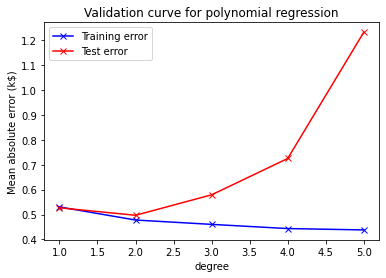

In [38]:
degree = [1, 2, 3, 4, 5]
train_scores, test_scores = validation_curve(
    poly_reg_pipeline, com_train_features, com_train_labels, param_name="poly__degree",
    param_range=degree, cv=cv, scoring="neg_mean_absolute_error", 
    n_jobs=2)   # "poly__degree" has double underscores

train_errors, test_errors = -train_scores, -test_scores
plt.plot(degree, train_errors.mean(axis=1), "b-x", label="Training error")
plt.plot(degree, test_errors.mean(axis=1), "r-x", label="Test error")
plt.legend()

plt.xlabel("degree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for polynomial regression")

# Note: The test set used here is the one created by the ShuffleSplit

We would select a degree for which the mean absolute error is the least. In this case, it is degree=2 that yields the least mean absolute error and that would be selected as an optimal degree for polynomial regression.  

# Ridge regression  

In [39]:
ridge_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                             ("ridge", Ridge(alpha=0.5))])
ridge_reg_cv_results = cross_validate(ridge_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

ridge_reg_train_error = -1 * ridge_reg_cv_results["train_score"]
ridge_reg_test_error = -1 * ridge_reg_cv_results["test_score"]

print(f"Mean absolute error of ridge regression model on the train set:\n"
      f"{ridge_reg_train_error.mean():.3f} +/- {ridge_reg_train_error.std():.3f}")

print(f"Mean absolute error of ridge regression model on the test set:\n"
      f"{ridge_reg_test_error.mean():.3f} +/- {ridge_reg_test_error.std():.3f}")

# Note: The test set used here is the one created by the ShuffleSplit

Mean absolute error of ridge regression model on the train set:
0.481 +/- 0.003
Mean absolute error of ridge regression model on the test set:
0.487 +/- 0.006


# HPT for ridge regularization rate  

HPT - Hyperparameter tuning  

In [40]:
alpha_list = np.logspace(-4, 0, num=20)
ridge_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                             ("ridge_cv", RidgeCV(alphas=alpha_list,
                                                  cv=cv,
                                                  scoring="neg_mean_absolute_error"))])

ridge_reg_cv_results = ridge_reg_pipeline.fit(com_train_features, com_train_labels)

In [41]:
print("The score with the best alpha is:",
      f"{ridge_reg_cv_results[-1].best_score_:.3f}")
print("The score error the best alpha is:",
      f"{-ridge_reg_cv_results[-1].best_score_:.3f}")

The score with the best alpha is: -0.473
The score error the best alpha is: 0.473


In [42]:
print("The best value for alpha:", ridge_reg_cv_results[-1].alpha_)

The best value for alpha: 0.007847599703514606


# `RidgeCV` with cross validation  

> **Exercise for us to do ** 
[Video link](https://youtu.be/SkL5TyjBiHQ?t=1120)

# Ridge HPT through `GridSearchCV`  

In [43]:
ridge_grid_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                                ("feature_scaling", StandardScaler()),
                                ("ridge", Ridge())])

param_grid = {"poly__degree": (1, 2, 3),
              "ridge__alpha": np.logspace(-4, 0, num=20)}

ridge_grid_search = GridSearchCV(ridge_grid_pipeline,
                                 param_grid=param_grid,
                                 n_jobs=2,
                                 cv=cv,
                                 scoring="neg_mean_absolute_error",
                                 return_train_score=True)

ridge_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaling', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=2,
             param_grid={'poly__degree': (1, 2, 3),
                         'ridge__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])},
             return_train_score=True, scoring='neg_mean_absolute_error')

`ridge_grid_search.best_index_` gives us the index of the best parameter in the list.  

In [44]:
mean_train_error = -1 * ridge_grid_search.cv_results_["mean_train_score"][ridge_grid_search.best_index_]
mean_test_error = -1 * ridge_grid_search.cv_results_["mean_test_score"][ridge_grid_search.best_index_]
std_train_error = ridge_grid_search.cv_results_["std_train_score"][ridge_grid_search.best_index_]
std_test_error = ridge_grid_search.cv_results_["std_test_score"][ridge_grid_search.best_index_]

print(f"Best Mean absolute error of polynomial ridge regression model on the train set:\n"
      f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Best Mean absolute error of polynomial ridge regression model on the test set:\n"
      f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

Best Mean absolute error of polynomial ridge regression model on the train set:
0.463 +/- 0.004
Best Mean absolute error of polynomial ridge regression model on the test set:
0.474 +/- 0.015


In [45]:
print("Mean cross validated score of the best estimator is: ", ridge_grid_search.best_score_)
print("Mean cross validated error of the best estimator is: ", -ridge_grid_search.best_score_)

Mean cross validated score of the best estimator is:  -0.4738651176991914
Mean cross validated error of the best estimator is:  0.4738651176991914


Note that this is same as the `RidgeCV` that we carried out earlier.  

In [46]:
print("The best parameter value is:", ridge_grid_search.best_params_)

The best parameter value is: {'poly__degree': 2, 'ridge__alpha': 0.007847599703514606}


# Lasso regression  

## Baseline model with fixed learning rate  

In [47]:
lasso_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                             ("lasso", Lasso(alpha=0.01))])
lasso_reg_cv_results = cross_validate(lasso_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

lasso_reg_train_error = -1 * lasso_reg_cv_results["train_score"]
lasso_reg_test_error = -1 * lasso_reg_cv_results["test_score"]

print(f"Mean absolute error of lasso regression model on the train set:\n"
      f"{lasso_reg_train_error.mean():.3f} +/- {lasso_reg_train_error.std():.3f}")

print(f"Mean absolute error of lasso regression model on the test set:\n"
      f"{lasso_reg_test_error.mean():.3f} +/- {lasso_reg_test_error.std():.3f}")

# Note: The test set used here is the one created by the ShuffleSplit

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.986e+01, tolerance: 1.654e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+01, tolerance: 1.669e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

Mean absolute error of lasso regression model on the train set:
0.529 +/- 0.003
Mean absolute error of lasso regression model on the test set:
0.528 +/- 0.008


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+01, tolerance: 1.658e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


# HPT for lasso regularization rate  

## With cross validation  

Exercise for us to do  
[Video link](https://youtu.be/SkL5TyjBiHQ?t=1355)

## With `GridSearchCV`  

In [70]:
lasso_grid_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                                ("feature_scaling", StandardScaler()),
                                ("lasso", Lasso())])

param_grid = {"poly__degree": (1, 2, 3), 
              "lasso__alpha": np.logspace(-4, 0, num=20)}

lasso_grid_search = GridSearchCV(lasso_grid_pipeline,
                                 param_grid=param_grid,
                                 n_jobs=2,
                                 cv=cv,
                                 scoring="neg_mean_absolute_error",
                                 return_train_score=True)

lasso_grid_search.fit(com_train_features, com_train_labels)

# This lasso regression not running for some reason.

KeyboardInterrupt: ignored

In [ ]:
mean_train_error = -1 * lasso_grid_search.cv_results_["mean_train_score"][lasso_grid_search.best_index_]
mean_test_error = -1 * lasso_grid_search.cv_results_["mean_test_score"][lasso_grid_search.best_index_]
std_train_error = lasso_grid_search.cv_results_["std_train_score"][lasso_grid_search.best_index_]
std_test_error = lasso_grid_search.cv_results_["std_test_score"][lasso_grid_search.best_index_]

print(f"Best Mean absolute error of polynomial lasso regression model on the train set:\n"
      f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Best Mean absolute error of polynomial lasso regression model on the test set:\n"
      f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

In [ ]:
print("Mean cross validated score of the best estimator is: ", lasso_grid_search.best_score_)
print("Mean cross validated error of the best estimator is: ", -lasso_grid_search.best_score_)

In [ ]:
print("The best parameter value is:", lasso_grid_search.best_params_)

# SGD: Regularization and HPT  

We can also perform regularization with SGD. `SGDRegressor` has many hyperparameters that require careful tuning to achieve the same performance as with `LinearRegression`.

In [51]:
poly_sgd_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                             ("sgd_reg", SGDRegressor(
                                 penalty="elasticnet",
                                 random_state=42))])

poly_sgd_cv_results = cross_validate(poly_sgd_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

poly_sgd_train_error = -1 * poly_sgd_cv_results["train_score"]
poly_sgd_test_error = -1 * poly_sgd_cv_results["test_score"]

print(f"Mean absolute error of SGD regression model on the train set:\n"
      f"{poly_sgd_train_error.mean():.3f} +/- {poly_sgd_train_error.std():.3f}")

print(f"Mean absolute error of SGD regression model on the test set:\n"
      f"{poly_sgd_test_error.mean():.3f} +/- {poly_sgd_test_error.std():.3f}")

# Note: The test set used here is the one created by the ShuffleSplit

Mean absolute error of SGD regression model on the train set:
10824283052.546 +/- 4423288211.832
Mean absolute error of SGD regression model on the test set:
10946788540.250 +/- 5396536227.703


Let's search for the best set of parameters for polynomial + SGD pipeline with `RandomizedSearchCV`.  
> Remember in `RandomizedSearchCV`, we need to specify distributions for hyperparameters.  


In [52]:
class uniform_int:
  """Integer valued version of the uniform distribution"""
  def __init__(self, a, b):
    self._distribution = uniform(a, b)

  def rvs(self, *args, **kwargs):
    """Random variable sample"""
    return self._distribution.rvs(*args, **kwargs).astype(int)

Let's specify `RandomizedSearchCV` set up.  

In [53]:
param_distributions = {
    'poly__degree': (1, 2, 3),
    'sgd_reg__learning_rate': ["constant", "adaptive", "invscaling"],
    'sgd_reg__l1_ratio': uniform(0, 1),
    'sgd_reg__eta0': loguniform(1e-5, 1),
    'sgd_reg__power_t': uniform(0.1)
}

poly_sgd_random_search = RandomizedSearchCV(
    poly_sgd_pipeline, param_distributions=param_distributions,
    n_iter=10, cv=cv, verbose=1, scoring="neg_mean_absolute_error"
)

poly_sgd_random_search.fit(com_train_features, com_train_labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
                   estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                             ('feature_scaling',
                                              StandardScaler()),
                                             ('sgd_reg',
                                              SGDRegressor(penalty='elasticnet',
                                                           random_state=42))]),
                   param_distributions={'poly__degree': (1, 2, 3),
                                        'sgd_reg__eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f548c85a110>,
                                        'sgd_reg__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f548c85aa50>,
                                        'sgd_reg__learning_rate': ['constant',
                                                                   'a

The best score can be obtained as follows:

In [54]:
poly_sgd_random_search.best_score_

-0.5266188964337121

The best set of parameters are obtained as follows:  

In [55]:
poly_sgd_random_search.best_params_

{'poly__degree': 1,
 'sgd_reg__eta0': 0.00017569928270100732,
 'sgd_reg__l1_ratio': 0.8686387810395121,
 'sgd_reg__learning_rate': 'adaptive',
 'sgd_reg__power_t': 0.7712948255943406}

And the best estimator can be accessed with the `best_estimator_` member variable.  

# Comparison of weight vectors

Let's look at the weight vectors produced by different models.  

In [56]:
feature_names = poly_reg_cv_results["estimator"][0][0].get_feature_names_out(
    input_features=train_features.columns)
feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge AveRooms', 'HouseAge AveBedrms', 'HouseAge Population',
       'HouseAge AveOccup', 'HouseAge Latitude', 'HouseAge Longitude',
       'AveRooms AveBedrms', 'AveRooms Population', 'AveRooms AveOccup',
       'AveRooms Latitude', 'AveRooms Longitude', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup Latitude', 'AveOccup Longitude',
       'Latitude Longitude'], dtype=object)

In [60]:
coefs = [est[-1].coef_ for est in poly_reg_cv_results["estimator"]]
weights_polynomial_regression = pd.DataFrame(coefs, columns=feature_names)

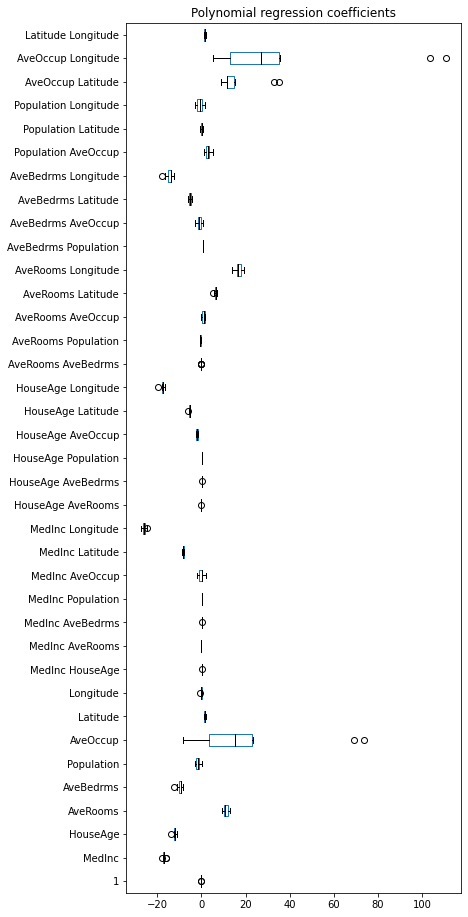

In [61]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_polynomial_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Polynomial regression coefficients")

In [63]:
feature_names  = ridge_reg_cv_results["estimator"][0][0].get_feature_names_out(
    input_features=train_features.columns)
feature_names

KeyError: ignored

In [ ]:
coefs = [est[-1].coef_ for est in ridge_reg_cv_results["estimator"]]
weights_ridge_regression = pd.DataFrame(coefs, columns=feature_names)

In [ ]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_ridge_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Polynomial regression coefficients")

# Performance on the test set  

> Note: This is the test set which we set aside in the very beginning of this colab notebook. It has so far not been used at all.  

## Baseline  

In [64]:
baseline_model_median = DummyRegressor(strategy="median")
baseline_model_median.fit(train_features, train_labels)
mean_absolute_percentage_error(test_labels,
                               baseline_model_median.predict(test_features))

0.5348927548151625

## Linear regression with normal equation  

In [65]:
mean_absolute_percentage_error(test_labels,
                               lin_reg_cv_results["estimator"][0].predict(test_features))

0.32120472175482906

## SGD regression  

In [66]:
mean_absolute_percentage_error(test_labels,
                               poly_sgd_random_search.predict(test_features))

0.31916692241957345

## Polynomial regression  

In [67]:
poly_reg_pipeline.fit(com_train_features, com_train_labels)
mean_absolute_percentage_error(test_labels,
                               poly_reg_pipeline.predict(test_features))

0.28199759082657244

## Ridge regression  

In [68]:
mean_absolute_percentage_error(test_labels,
                               ridge_grid_search.best_estimator_.predict(test_features))

0.27110336451421413

## Lasso regression  

Lasso regression not running for some reason  

In [69]:
mean_absolute_percentage_error(test_labels,
                               lasso_grid_search.best_estimator_.predict(test_features))

AttributeError: ignored

# Summary  

We trained multiple linear regression models on housing dataset, set their hyperparameters through hyperparameter optimization, retrained models with the best values of hyperparameters and then evaluated their performance on the test data (that was held back until final evaluation).  

This is how most of the real world problems are solved starting from simple models to more sophisticated models.  